# LOFAR OPC UA single station imaging

In [1]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from lofarantpos.db import LofarAntennaDatabase

In [3]:
from lofarimaging import make_sky_plot, make_ground_plot, apply_calibration, get_station_pqr, \
    freq_from_sb, sky_imager, skycoord_to_lmn, nearfield_imager, get_map, make_leaflet_map, make_xst_plots

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
station_name = "RS210"
subband = 250
integration_time_s = 2

In [6]:
db = LofarAntennaDatabase()

# OPC UA demo

In [7]:
from opcua import Client

In [8]:
client = Client("opc.tcp://{}:{}/".format('localhost', 50000), timeout=1000)
client

In [9]:
client.connect()

In [10]:
client.load_type_definitions()

([], {})

In [11]:
objects = client.get_objects_node()
objects

Node(TwoByteNodeId(i=85))

In [12]:
idx = client.get_namespace_index('http://lofar.eu')
idx

2

In [13]:
obj = client.get_root_node().get_child(["0:Objects",
                                        "{}:StationMetrics".format(idx),
                                        "{}:RCU".format(idx)])
obj

Node(NumericNodeId(ns=2;i=2))

In [14]:
obstime, visibilities_opc, rcu_modes = obj.call_method("{}:record_cross".format(idx), subband, integration_time_s)
obstime

datetime.datetime(2020, 3, 18, 9, 0, 17, 78872)

In [15]:
client.close_session()
client.close_secure_channel()

# Wrapped OPC UA

In [16]:
from lofarimaging.opc_interface import download_xst

In [31]:
%time obstime, visibilities, rcu_mode = download_xst(subband, integration_time_s)
rcu_mode

CPU times: user 21.2 ms, sys: 6.33 ms, total: 27.5 ms
Wall time: 7.44 s


2

# Do imaging

In [32]:
obstime

datetime.datetime(2020, 3, 18, 9, 3, 31, 56781)

In [33]:
# HACK to be able to test when station is off
if rcu_mode == 0:
    print("Station is in mode 0, pretending it's in mode 3 to test")
    rcu_mode = 3

In [34]:
visibilities.shape

(96, 96)

In [35]:
fname = f"{obstime:%Y%m%d_%H%M%S}_{station_name}_SB{subband}"

In [36]:
visibilities, calibration_info = apply_calibration(visibilities, station_name,
                                                   rcu_mode, subband)

In [37]:
visibilities = visibilities[0::2, 0::2] + visibilities[1::2, 1::2]

In [38]:
station_name += "LBA"

In [39]:
station_pqr = get_station_pqr(station_name, rcu_mode, db)

In [40]:
# Rotate station_pqr to a north-oriented xyz frame, where y points North, in a plane through the station.
rotation = db.rotation_from_north(station_name)
print ('Rotation for %s: %.2f deg' % (station_name, rotation))

Rotation for RS210LBA: 0.00 deg


In [41]:
pqr_to_xyz = np.array([[np.cos(-rotation), -np.sin(-rotation), 0],
                       [np.sin(-rotation),  np.cos(-rotation), 0],
                       [                0,                  0, 1]])

In [42]:
station_xyz = (pqr_to_xyz @ station_pqr.T).T

In [43]:
# For every antenna, calculate the distance between it and every other antenna
baselines = station_xyz[:, np.newaxis, :] - station_xyz[np.newaxis, :, :]

In [44]:
freq = freq_from_sb(subband, rcu_mode = rcu_mode)

In [45]:
visibilities.shape

(48, 48)

In [46]:
# Fourier transform
%time sky_img = sky_imager(visibilities, baselines, freq, 103, 103)

CPU times: user 4.31 s, sys: 516 ms, total: 4.83 s
Wall time: 7.55 s


In [47]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, GCRS, AltAz, get_sun
import astropy.units as u

In [48]:
obstime_astropy = Time(obstime)

station_earthlocation = EarthLocation.from_geocentric(*(db.phase_centres[station_name] * u.m))
zenith = AltAz(az=0 * u.deg, alt=90 * u.deg, obstime=obstime_astropy,
               location=station_earthlocation).transform_to(GCRS)

marked_bodies = {
    'Cas A': SkyCoord(ra=350.85*u.deg, dec=58.815*u.deg),
    'Cyg A': SkyCoord(ra=299.868*u.deg, dec=40.734*u.deg),
    'Sun': get_sun(obstime_astropy)
}

marked_bodies_lmn = {}
for body_name, body_coord in marked_bodies.items():
    if body_coord.transform_to(AltAz(location=station_earthlocation, obstime=obstime_astropy)).alt > 0:
        marked_bodies_lmn[body_name] = skycoord_to_lmn(marked_bodies[body_name], zenith)

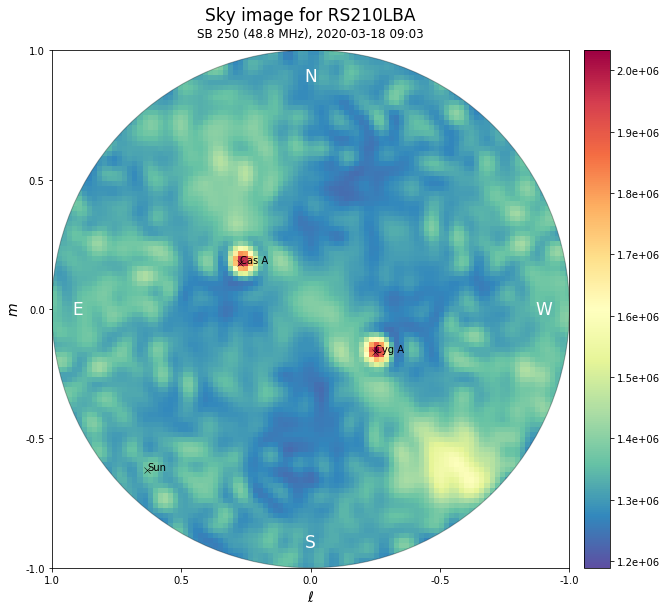

In [49]:
fig = make_sky_plot(sky_img, marked_bodies_lmn, title=f"Sky image for {station_name}",
                    subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}");

In [50]:
fig.savefig(os.path.join('results', f'{fname}_sky_calibrated.png'), bbox_inches='tight', dpi=200)
plt.close(fig)

In [51]:
ground_resolution = 0.5
height = 1.5

In [52]:
extent = [-700, 100, -700, 60]

In [53]:
npix_x, npix_y = int(ground_resolution * (extent[1] - extent[0])), int(ground_resolution * (extent[3] - extent[2]))

In [54]:
os.environ["NUMEXPR_NUM_THREADS"] = "3"

In [55]:
# Select a subset of visibilities, only the lower triangular part
baseline_indices = np.tril_indices(visibilities.shape[0])

In [56]:
visibilities_selection = visibilities[baseline_indices]

In [57]:
%time ground_img = nearfield_imager(visibilities_selection.flatten()[:,np.newaxis], \
                             np.array(baseline_indices).T, \
                             [freq], npix_x, npix_y, extent, station_xyz, height=height)

CPU times: user 10.7 s, sys: 4.46 s, total: 15.1 s
Wall time: 18.6 s


In [58]:
# Correct for taking only lower triangular part
ground_img = np.real(2 * ground_img)

In [59]:
import lofargeotiff

In [60]:
# Convert bottom left and upper right to PQR just for lofargeo
pmin, qmin, _ = pqr_to_xyz.T @ (np.array([extent[0], extent[2], 0]))
pmax, qmax, _ = pqr_to_xyz.T @ (np.array([extent[1], extent[3], 0]))
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0, 0, 0], station_name)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station_name)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station_name)

In [61]:
background_map = get_map(lon_min, lon_max, lat_min, lat_max, 19)

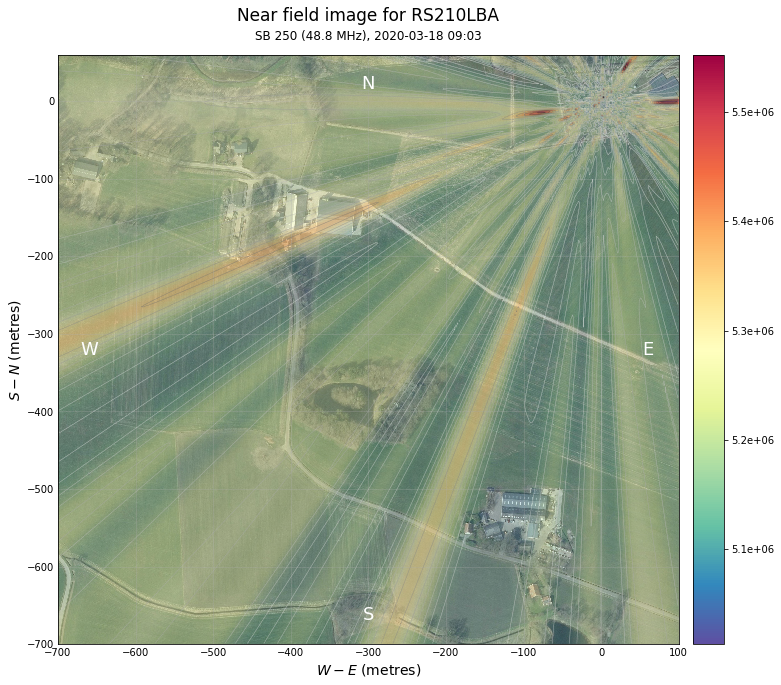

In [65]:
fig, folium_overlay = make_ground_plot(ground_img, background_map, extent,
                                       title=f"Near field image for {station_name}",
                                       subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}",
                                       opacity=0.6)

In [63]:
maxpixel_ypix, maxpixel_xpix = np.unravel_index(np.argmax(ground_img), ground_img.shape)
maxpixel_x = np.interp(maxpixel_xpix, [0, npix_x], [extent[0], extent[1]])
maxpixel_y = np.interp(maxpixel_ypix, [0, npix_y], [extent[2], extent[3]])
[maxpixel_p, maxpixel_q, _] = pqr_to_xyz.T @ np.array([maxpixel_x, maxpixel_y, height])
maxpixel_lon, maxpixel_lat, _ = lofargeotiff.pqr_to_longlatheight([maxpixel_p, maxpixel_q], station_name)

In [64]:
# Show location of maximum if not at the image border
if 5 < maxpixel_xpix < npix_x - 5 and 5 < maxpixel_ypix < npix_y - 5:
    print(f"Maximum at {maxpixel_x:.0f}m east, {maxpixel_y:.0f}m north of station center (lat/long {maxpixel_lat:.5f}, {maxpixel_lon:.5f})")

Maximum at 84m east, -2m north of station center (lat/long 52.33087, 6.87481)


Export the near field image to GeoTIFF for archiving and viewing in other tools (QGIS).

In [66]:
tags = {"generated_with": f"lofarimaging over OPC UA",
        "subband": subband,
        "frequency": freq,
        "extent_xyz": extent,
        "height": height,
        "station": station_name}
tags.update(calibration_info)
lofargeotiff.write_geotiff(ground_img, f"results/{fname}_nearfield_calibrated.tiff",
                           (pmin, qmin), (pmax, qmax), stationname=station_name,
                           obsdate=obstime, tags=tags)

Overlay the near field image on a map.

In [67]:
make_leaflet_map(folium_overlay, lon_center, lat_center, lon_min, lat_min, lon_max, lat_max)